In [1]:
from __future__ import print_function, division
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sklearn
import seaborn as sns
import json
from pandas.io.json import json_normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA
%matplotlib inline

In [2]:
# dataexploration.ipynb

train_ingr = []
train_id = []
train_cuisine = []

test_ingr = []
test_id = []

with open('data/train.json') as json_file:  
    dict_train = json.load(json_file)
    
with open('data/test.json') as json_file:  
    dict_test = json.load(json_file)

for train_recipe in dict_train:
    concat_ingr_tr = ' '.join([word.replace(" ", "_") for word in train_recipe['ingredients']])
    train_ingr.append(concat_ingr_tr)
    train_id.append(train_recipe['id'])
    train_cuisine.append(train_recipe['cuisine']) # all vocab
        
for test_recipe in dict_test:
    concat_ingr_ts = ' '.join([word.replace(" ", "_") for word in test_recipe['ingredients']])
    test_ingr.append(concat_ingr_ts)  
    test_id.append(test_recipe['id'])

vectorizer = CountVectorizer()

X_train = pd.DataFrame(vectorizer.fit_transform(train_ingr).todense())
X_test  = pd.DataFrame(vectorizer.transform(test_ingr).todense())

X_train.columns = vectorizer.vocabulary_.keys()
X_test.columns = vectorizer.vocabulary_.keys()

X_train['id'] = train_id
X_test['id'] = test_id

X_train['cuisine'] = train_cuisine

In [3]:
X_test['cuisine'] = 'unknown'
data = [X_train, X_test]
full_data = pd.concat(data)

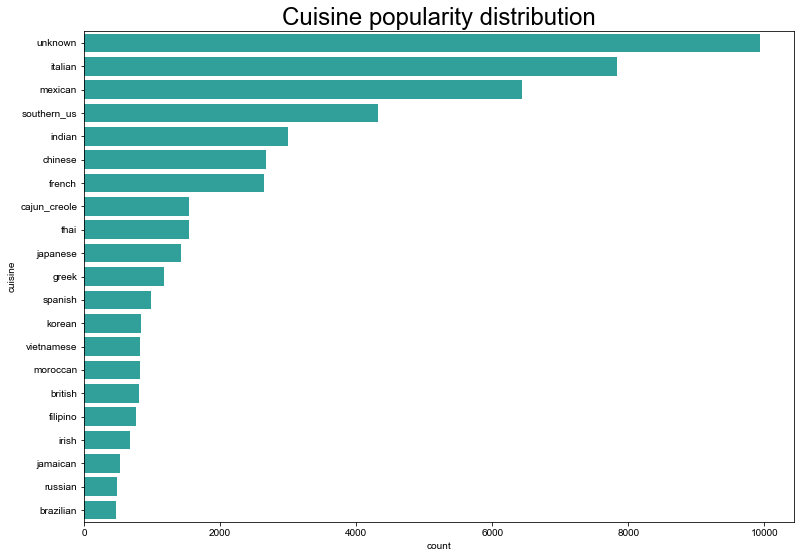

In [4]:
# how sparse the data is 

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)


cuisine_counts = full_data.groupby('cuisine').cuisine.count()
cuisine_counts = pd.DataFrame({'cuisine': cuisine_counts.index, 'count': cuisine_counts.values})
cuisine_counts = cuisine_counts.sort_values(['count'], ascending=False)
sns.set(font_scale=2)
sns.set_style("whitegrid")

plt.title("Cuisine popularity distribution")

_ = sns.barplot(ax=ax, x='count', y='cuisine', data=cuisine_counts, orient='h', label='big', color='lightseagreen')
plt.tight_layout()
fig.savefig('cuisine_popularity.pdf')

In [5]:
#6867 ingredients in total
full_data["number_of_ingredients"] = full_data.iloc[:, :-2].sum(axis=1)

In [6]:
full_data.shape #49718 total examples (including unknown)

(49718, 6870)

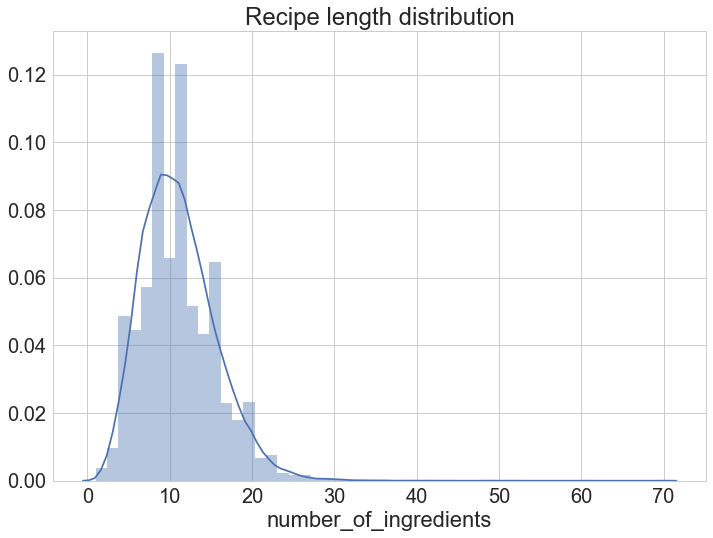

In [12]:
# number of ingredients per recipe

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.title("Recipe length distribution")
_ = sns.distplot(full_data['number_of_ingredients'], kde=True, label="big")
fig.savefig('recipes_length.pdf')

In [ ]:
# skewed distribution, outliers: very long and very short recipes

In [8]:
no_outliers = full_data.loc[full_data['number_of_ingredients'].isin(range(4, 30))]

In [9]:
no_outliers.shape

(48732, 6870)

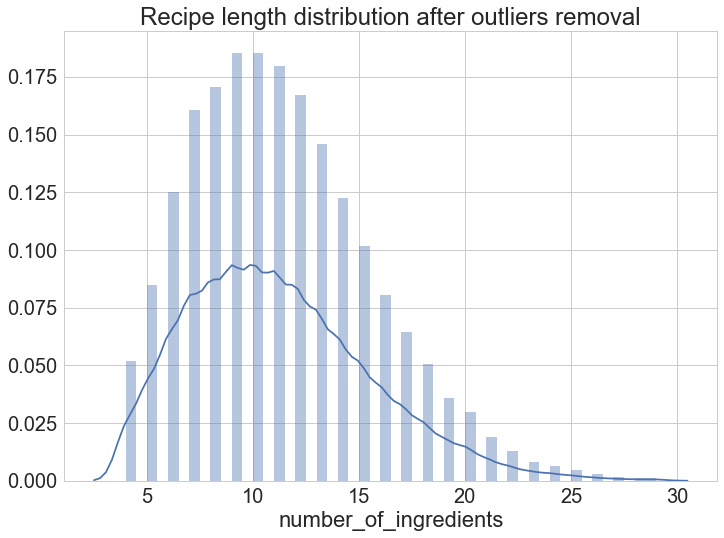

In [13]:
# Recipe length distribution after removing outliers

fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.title("Recipe length distribution after outliers removal")
_ = sns.distplot(no_outliers['number_of_ingredients'])
fig.savefig('recipes_length_no_outliers.pdf')

In [45]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(no_outliers.iloc[:, :-3])

In [48]:
# Percentage of variance explained for each components
print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))

explained variance ratio (first two components): [0.0298653  0.02821523]


In [70]:
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'navy', 'turquoise', 'darkorange', 'black', 'coral', 'fuchsia', 'lightblue', 'grey', 'lavender', 'plum', 'tan', 'teal', 'violet', 'salmon', 'darkgreen']

In [71]:
cuisines = no_outliers['cuisine'].values
print(len(set(cuisines)))
print(len(colors))

21
21


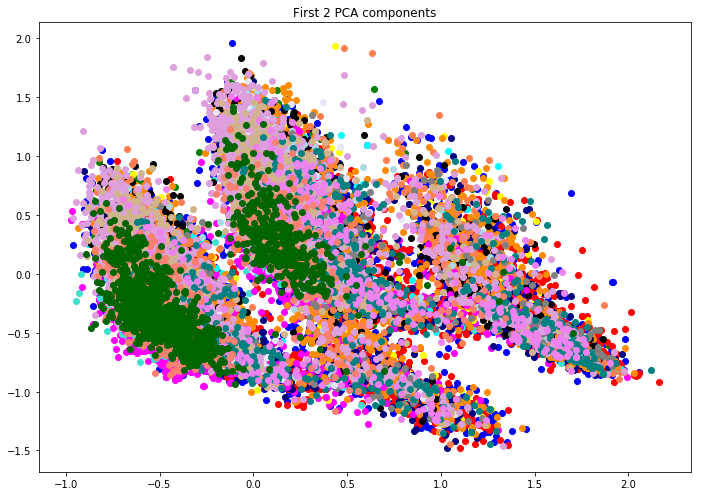

In [75]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.title("First 2 PCA components")
for i, cur_cuisine in enumerate(set(cuisines)):
    plt.scatter(X_pca[cuisines == cur_cuisine, 0], X_pca[cuisines == cur_cuisine, 1], c=colors[i])

fig.savefig('pca.pdf')

In [76]:
# group by location
print(set(cuisines))

{'unknown', 'moroccan', 'southern_us', 'jamaican', 'chinese', 'greek', 'french', 'vietnamese', 'italian', 'indian', 'cajun_creole', 'japanese', 'filipino', 'irish', 'brazilian', 'mexican', 'spanish', 'british', 'russian', 'korean', 'thai'}


In [106]:
west = ['french', 'irish', 'british', 'russian', 'cajun_creole'] # Europe and US
east = ['chinese', 'vietnamese', 'japanese', 'filipino', 'korean', 'thai']
south = ['southern_us', 'jamaican', 'mexican', 'brazilian']
mediterranean = ['greek', 'spanish', 'italian', 'moroccan']
indian = ['indian']

def label_origin(row):
    if row['cuisine'] in west:
        return 'west'
    if row['cuisine'] in east:
        return 'east'
    if row['cuisine'] in mediterranean:
        return 'mediterranean'
    if row['cuisine'] in indian:
        return 'indian'
    if row['cuisine'] in south:
        return 'south'

X_train['origin'] = X_train.apply (lambda row: label_origin(row),axis=1)

    
colors = ['blue', 'green', 'red', 'yellow', 'pink']
origins = X_train['origin'].values

# smarter method...

In [108]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train.iloc[:, :-3])

In [107]:
print(set(origins))

{'south', 'west', 'east', 'indian', 'mediterranean'}


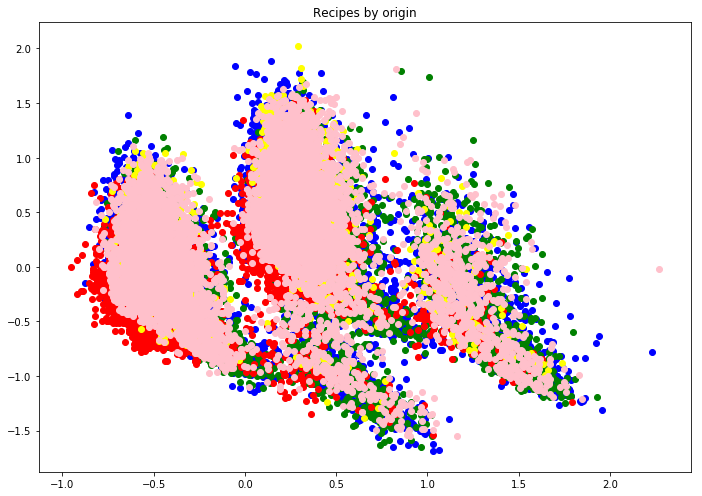

In [109]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

plt.title("Recipes by origin")
for i, cur_origin in enumerate(set(origins)):
    plt.scatter(X_pca[origins == cur_origin, 0], X_pca[origins == cur_origin, 1], c=colors[i])

fig.savefig('pca_origins.pdf')

interpretation: 2 first PCA components aren't enough to represent the data (explained variance ratio (first two components): [0.0298653  0.02821523])

# PCA on the transposed matrix, labels instead of dots (sort the ingredients, take the most common ones)
# tSNE
# tf-idf

In [11]:
transposed = no_outliers.transpose().iloc[:-3, :]

In [30]:
transposed['count'] = transposed.sum(axis=1) # number of ingredients

In [34]:
transposed['name'] = transposed.index.values

In [35]:
transposed

,0,1,2,3,4,5,6,7,8,9,...,9936,9937,9938,9939,9940,9941,9942,9943,count,name
romaine_lettuce,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,romaine_lettuce
black_olives,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,black_olives
grape_tomatoes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.0,grape_tomatoes
garlic,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,garlic
pepper,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3.0,pepper
purple_onion,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.0,purple_onion
seasoning,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2.0,seasoning
garbanzo_beans,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8.0,garbanzo_beans
feta_cheese_crumbles,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,14.0,feta_cheese_crumbles
plain_flour,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,5.0,plain_flour


In [38]:
transposed = transposed.sort_values(['count'], ascending=False).iloc[:100]
transposed

,0,1,2,3,4,5,6,7,8,9,...,9936,9937,9938,9939,9940,9941,9942,9943,count,name
beef_hot_dogs,0,1,1,1,1,1,1,0,1,0,...,1,0,1,1,1,1,1,0,22439.0,beef_hot_dogs
crumb_crust,0,0,0,0,1,0,0,0,0,0,...,0,1,1,0,0,0,0,0,9965.0,crumb_crust
long_green_beans,0,0,0,0,0,0,1,1,1,0,...,0,0,1,0,0,0,0,1,9821.0,long_green_beans
mandarin_orange_juice,0,0,0,1,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,9154.0,mandarin_orange_juice
turkey_sausage,1,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,9121.0,turkey_sausage
chicken_demi,0,0,0,0,0,1,0,1,0,0,...,1,1,0,1,0,0,0,0,7956.0,chicken_demi
corn_mix_muffin,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,7735.0,corn_mix_muffin
grana_padano,0,0,1,0,1,1,0,0,0,0,...,0,0,0,0,1,0,1,0,6052.0,grana_padano
cream_of_celery_soup,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,5965.0,cream_of_celery_soup
firm_tofu,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,5791.0,firm_tofu


In [39]:
ingr_count = no_outliers.sum(axis=0)

TypeError: cannot label index with a null key

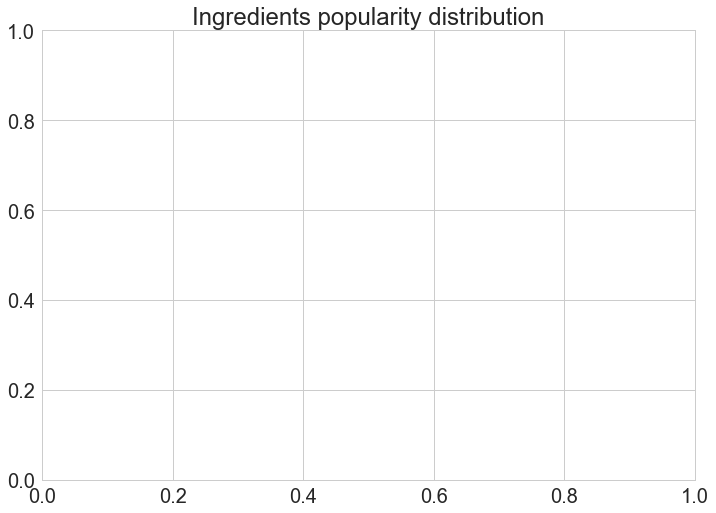

In [37]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)


transposed = transposed.sort_values(['count'], ascending=False).iloc[:100]
sns.set(font_scale=2)
sns.set_style("whitegrid")

plt.title("Ingredients popularity distribution")

_ = sns.barplot(ax=ax, x='count', y='name', data=transposed, orient='h', label='big', color='lightseagreen')
plt.tight_layout()
fig.savefig('ingredient_popularity.pdf')

In [17]:
ingredients = transposed.index.values
ingredients

array(['romaine_lettuce', 'black_olives', 'grape_tomatoes', ...,
       'lop_chong', 'tomato_garlic_pasta_sauce',
       'crushed_cheese_crackers'], dtype=object)

In [18]:
top_ingredients = 

,0,1,2,3,4,5,6,7,8,9,...,9934,9935,9936,9937,9938,9939,9940,9941,9942,9943
romaine_lettuce,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
black_olives,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
grape_tomatoes,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
garlic,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pepper,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
purple_onion,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
seasoning,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
garbanzo_beans,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
feta_cheese_crumbles,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
plain_flour,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [22]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(transposed[:100])

In [24]:
df = pd.DataFrame(X_pca, index=ingredients[:100], columns=['x', 'y'])

In [25]:
df

,x,y
romaine_lettuce,-0.210538,-0.173572
black_olives,-0.213316,-0.176995
grape_tomatoes,-0.206076,-0.167783
garlic,-0.206574,-0.168403
pepper,-0.208082,-0.170293
purple_onion,-0.210168,-0.172964
seasoning,-0.210168,-0.172964
garbanzo_beans,-0.212759,-0.113372
feta_cheese_crumbles,-0.219618,-0.185083
plain_flour,-0.213316,-0.176995


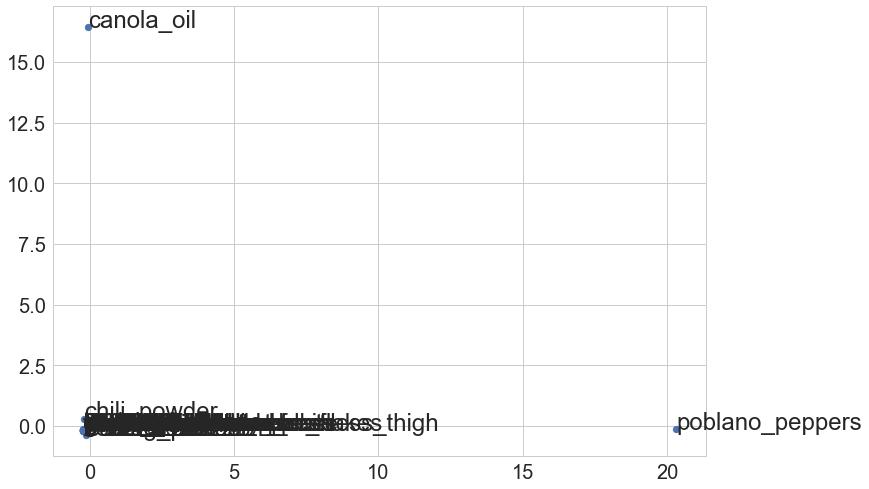

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(11.7, 8.27)

ax.scatter(df['x'], df['y'])
for word, pos in df.iterrows():
    ax.annotate(word, pos)
    
fig.savefig("PCA.pdf")   

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(transposed)

In [ ]:
X_tsne

In [ ]:
X_pca